<a href="https://colab.research.google.com/github/Jarvis017/Text-Summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis

In [1]:
!pip install lexrank fireducks
!pip install transformers diffusers huggingface_hub langchain openai langchain_together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 69.4 MB/s eta 0:

## Imports

In [27]:
from google.colab import drive
from transformers import pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from tqdm import trange
from nltk.corpus import stopwords
import re
import nltk
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
import requests
from PIL import Image
from io import BytesIO
import IPython.display as display
from langchain_together import ChatTogether, Together
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
nltk.download('punkt')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
nltk.download('stopwords')
drive.mount("/content/gdrive")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load the data

In [3]:
data = pd.read_csv('/content/gdrive/My Drive/dataset/booksummaries.txt', delimiter='\t', header=None)
data

,0,1,2,3,4,5,6
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [4]:
data = data.rename(columns={6: 'story'})
data.head(10)

,0,1,2,3,4,5,story
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


## Length of each story(character based)

In [5]:
data['Length'] = data['story'].str.len()
data

,0,1,2,3,4,5,story,Length
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493
...,...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",961
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,1229
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,1841
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...,147


## Number of words of each story

In [6]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [7]:
data['Word_count'] = data['story'].apply(word_count)
data.head(10)

,0,1,2,3,4,5,story,Length,Word_count
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812,957
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121,998
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642,1119
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134,2825
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493,722
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",4283,770
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",5850,1066
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...,7263,1297
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...",319,56
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,1786,291


In [8]:
data = data.drop([0, 1, 2, 3, 4, 5], axis=1)
data

,story,Length,Word_count
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957
1,"Alex, a teenager living in near-future Englan...",6121,998
2,The text of The Plague is divided into five p...,6642,1119
3,The argument of the Enquiry proceeds by a ser...,17134,2825
4,The novel posits that space around the Milky ...,4493,722
...,...,...,...
16554,"Prue McKeel, having rescued her brother from ...",961,151
16555,The reader first meets Rapp while he is doing...,1229,211
16556,The book follows very rough chronological ord...,1841,307
16557,Colbert addresses topics including Wall Stree...,147,20


## Mean number of words of stories

In [9]:
data['mean_word_length'] = data['story'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,story,Length,Word_count,mean_word_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267
2,The text of The Plague is divided into five p...,6642,1119,4.935657
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133
4,The novel posits that space around the Milky ...,4493,722,5.222992
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805
7,The story is set in an imaginary American tow...,7263,1297,4.599846
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429
9,Beginning several months after the events in ...,1786,291,5.137457


## Mean number of sententes length

In [10]:
data['mean_sentence_length'] = data['story'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,story,Length,Word_count,mean_word_length,mean_sentence_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338,103.487805
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805,111.519231
7,The story is set in an imaginary American tow...,7263,1297,4.599846,109.060606
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429,105.666667
9,Beginning several months after the events in ...,1786,291,5.137457,148.000000


## Most frequent words

In [11]:
def cleaner(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [12]:
data['clean story'] = data['story'].apply(cleaner)
data.head(10)

,story,Length,Word_count,mean_word_length,mean_sentence_length,clean story
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,old major old boar manor farm calls animals fa...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,alex teenager living near-future england leads...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,text plague divided five parts town oran thous...
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,argument enquiry proceeds series incremental s...
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits space around milky way divided co...
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338,103.487805,book tells story paul bumer german soldier who...
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805,111.519231,ged young boy gont one larger islands north ar...
7,The story is set in an imaginary American tow...,7263,1297,4.599846,109.060606,story set imaginary american town gone bankrup...
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429,105.666667,living mars deckard acting consultant movie cr...
9,Beginning several months after the events in ...,1786,291,5.137457,148.000000,beginning several months events blade runner d...


In [13]:
def splitter(text):
    text_list = text.split()
    return text_list

In [14]:
data['clean story list'] = data['clean story'].apply(splitter)
data.head(10)

,story,Length,Word_count,mean_word_length,mean_sentence_length,clean story,clean story list
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,old major old boar manor farm calls animals fa...,"[old, major, old, boar, manor, farm, calls, an..."
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,alex teenager living near-future england leads...,"[alex, teenager, living, near-future, england,..."
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,text plague divided five parts town oran thous...,"[text, plague, divided, five, parts, town, ora..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,argument enquiry proceeds series incremental s...,"[argument, enquiry, proceeds, series, incremen..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits space around milky way divided co...,"[novel, posits, space, around, milky, way, div..."
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338,103.487805,book tells story paul bumer german soldier who...,"[book, tells, story, paul, bumer, german, sold..."
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805,111.519231,ged young boy gont one larger islands north ar...,"[ged, young, boy, gont, one, larger, islands, ..."
7,The story is set in an imaginary American tow...,7263,1297,4.599846,109.060606,story set imaginary american town gone bankrup...,"[story, set, imaginary, american, town, gone, ..."
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429,105.666667,living mars deckard acting consultant movie cr...,"[living, mars, deckard, acting, consultant, mo..."
9,Beginning several months after the events in ...,1786,291,5.137457,148.000000,beginning several months events blade runner d...,"[beginning, several, months, events, blade, ru..."


In [15]:
data['clean story list'][0]

['old',
 'major',
 'old',
 'boar',
 'manor',
 'farm',
 'calls',
 'animals',
 'farm',
 'meeting',
 'compares',
 'humans',
 'parasites',
 'teaches',
 'animals',
 'revolutionary',
 'song',
 'beasts',
 'england',
 'major',
 'dies',
 'two',
 'young',
 'pigs',
 'snowball',
 'napoleon',
 'assume',
 'command',
 'turn',
 'dream',
 'philosophy',
 'animals',
 'revolt',
 'drive',
 'drunken',
 'irresponsible',
 'mr',
 'jones',
 'farm',
 'renaming',
 'animal',
 'farm',
 'adopt',
 'seven',
 'commandments',
 'animal-ism',
 'important',
 'animals',
 'equal',
 'snowball',
 'attempts',
 'teach',
 'animals',
 'reading',
 'writing',
 'food',
 'plentiful',
 'farm',
 'runs',
 'smoothly',
 'pigs',
 'elevate',
 'positions',
 'leadership',
 'set',
 'aside',
 'special',
 'food',
 'items',
 'ostensibly',
 'personal',
 'health',
 'napoleon',
 'takes',
 'pups',
 'farm',
 'dogs',
 'trains',
 'privately',
 'napoleon',
 'snowball',
 'struggle',
 'leadership',
 'snowball',
 'announces',
 'plans',
 'build',
 'windmill',

In [16]:
texts = []
for i in trange(data.shape[0], ncols=180, nrows=10, colour='red', smoothing=0.8):
    texts += data['clean story list'][i]
len(texts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16559/16559 [00:00<00:00, 125780.28it/s]


3856251

In [17]:
mostCommon = Counter(texts).most_common(10)
mostCommon

[('one', 17745),
 ('time', 11497),
 ('also', 11223),
 ('two', 11122),
 ('new', 10407),
 ('life', 10014),
 ('back', 9694),
 ('first', 8905),
 ('book', 8638),
 ('story', 8491)]

In [18]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

<ipython-input-19-233dccce9b41>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq, y=words,palette='Set2')


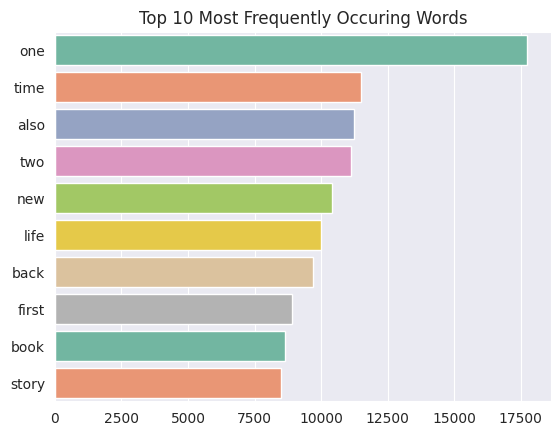

In [19]:
sns.barplot(x=freq, y=words,palette='Set2')
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

# Summarization

## Lex rank (first approach)

In [20]:
#lxr = LexRank(data["story"], stopwords=STOPWORDS['en'])

In [28]:

stories = data['story'].tolist()

# Tokenize each story into sentences
documents = [sent_tokenize(story) for story in stories]

# Initialize LexRank with the stories themselves as background documents
lexrank = LexRank(documents, stopwords=STOPWORDS['en'])

# Function to summarize each story
def summarize_story(story, summary_size=2):
    # Split the story into sentences
    sentences = sent_tokenize(story)

    # If the story has fewer sentences than the summary size, return the full story
    if len(sentences) <= summary_size:
        return story

    # Get the summary from LexRank
    summary = lexrank.get_summary(sentences, summary_size=summary_size)

    # Join the summary sentences into a single string
    return ' '.join(summary)

# Apply summarization to each story in the dataset
data['lex summary'] = data['story'].apply(lambda story: summarize_story(story, summary_size=2))

# View the dataset with summaries
print(data[['story', 'lex summary']].head())


                                               story  \
0   Old Major, the old boar on the Manor Farm, ca...   
1   Alex, a teenager living in near-future Englan...   
2   The text of The Plague is divided into five p...   
3   The argument of the Enquiry proceeds by a ser...   
4   The novel posits that space around the Milky ...   

                                         lex summary  
0  This is an ironic twist to the original purpos...  
1  The prison chaplain mistakes Alex's Bible stud...  
2  Dr. Rieux consults his colleague, Castel, abou...  
3  (Hume 1974:389) And there are a number of reas...  
4  After arriving at the Tines homeworld and ally...  


In [30]:
data["lex summary"].to_csv('lex summary.csv', index=False)

In [31]:
data["story"][0], data["lex summary"][0]

(' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. 

## T5 model (second Approach)

### Load summarization pipeline (T5-base)

In [35]:
summarizer = pipeline("summarization", min_length = 100, max_length = 300, model="t5-base", device = 0)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Get sample from data

In [36]:
sample = data.iloc[:500]
sample

,story,Length,Word_count,mean_word_length,mean_sentence_length,clean story,clean story list,lex summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,old major old boar manor farm calls animals fa...,"[old, major, old, boar, manor, farm, calls, an...",This is an ironic twist to the original purpos...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,alex teenager living near-future england leads...,"[alex, teenager, living, near-future, england,...",The prison chaplain mistakes Alex's Bible stud...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,text plague divided five parts town oran thous...,"[text, plague, divided, five, parts, town, ora...","Dr. Rieux consults his colleague, Castel, abou..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,argument enquiry proceeds series incremental s...,"[argument, enquiry, proceeds, series, incremen...",(Hume 1974:389) And there are a number of reas...
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits space around milky way divided co...,"[novel, posits, space, around, milky, way, div...",After arriving at the Tines homeworld and ally...
...,...,...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,first brothers particularly peaceful lot end q...,"[first, brothers, particularly, peaceful, lot,...","Still, the tone of the tale is not particularl..."
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,book presented manuscript protagonist middle-a...,"[book, presented, manuscript, protagonist, mid...","After attending a lavish masquerade ball, Pabl..."
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,fleming structured novel three sectionshappens...,"[fleming, structured, novel, three, sectionsha...",Bond foils an assassination attempt on Goldfin...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed set great depression tells story fran...,"[ironweed, set, great, depression, tells, stor...",The novel features characters that return in s...


### Run summarization process

In [37]:
tqdm.pandas()
sample['t5 summary'] = sample['story'].progress_apply(
        lambda story: summarizer(story)[0]['summary_text'])
sample

100%|██████████| 500/500 [21:52<00:00,  2.63s/it]
<ipython-input-37-40132ac1fcbe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['t5 summary'] = sample['story'].progress_apply(


,story,Length,Word_count,mean_word_length,mean_sentence_length,clean story,clean story list,lex summary,t5 summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,old major old boar manor farm calls animals fa...,"[old, major, old, boar, manor, farm, calls, an...",This is an ironic twist to the original purpos...,john sutter: the original purpose of the Seven...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,alex teenager living near-future england leads...,"[alex, teenager, living, near-future, england,...",The prison chaplain mistakes Alex's Bible stud...,characterized as a sociopath and a hardened ju...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,text plague divided five parts town oran thous...,"[text, plague, divided, five, parts, town, ora...","Dr. Rieux consults his colleague, Castel, abou...","the plague is sweeping the town of Oran, where..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,argument enquiry proceeds series incremental s...,"[argument, enquiry, proceeds, series, incremen...",(Hume 1974:389) And there are a number of reas...,"s.e. cuthbertson: in the Enquiry, he argues th..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits space around milky way divided co...,"[novel, posits, space, around, milky, way, div...",After arriving at the Tines homeworld and ally...,novel posits that space around the Milky Way i...
...,...,...,...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,first brothers particularly peaceful lot end q...,"[first, brothers, particularly, peaceful, lot,...","Still, the tone of the tale is not particularl...",young girls' mothers do not regard them as goo...
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,book presented manuscript protagonist middle-a...,"[book, presented, manuscript, protagonist, mid...","After attending a lavish masquerade ball, Pabl...",a middle-aged man named Harry Haller is beset ...
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,fleming structured novel three sectionshappens...,"[fleming, structured, novel, three, sectionsha...",Bond foils an assassination attempt on Goldfin...,'happenstance' is about a british secret servi...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed set great depression tells story fran...,"[ironweed, set, great, depression, tells, stor...",The novel features characters that return in s...,ironweed tells the story of an alcoholic vagra...


In [38]:
sample.to_csv('t5 summary.csv', index=False)

In [39]:
sample.story.iloc[30]

' "Starting in the Middle", Part I of Darwin\'s Dangerous Idea, gets its name from a quote by Willard Van Orman Quine: "Analyze theory-building how we will, we all must start in the middle. Our conceptual firsts are middle-sized, middle-distance objects, and our introduction to them and to everything comes midway in the cultural evolution of the race." The first chapter "Tell Me Why" is named after a song. Before Charles Darwin, God was seen as the ultimate cause of all design, or the ultimate answer to \'why?\' questions. John Locke argued for the primacy of mind before matter, and David Hume, while exposing problems with Locke\'s view, could not see any alternative. Darwin provided just such an alternative: evolution. Besides providing evidence of common descent, he introduced a mechanism to explain it: natural selection. According to Dennett, natural selection is a mindless, mechanical and algorithmic process&mdash;Darwin\'s dangerous idea. The third chapter introduces the concept o

In [49]:
sample["t5 summary"][30]

'"Starting in the middle" is part I of Darwin\'s Dangerous Idea . the book discusses the origin and evolution of morality . it concludes by asking if ethics can be \'naturalized\' the book concludes with "the future of an idea" the author concludes that morality is the product of \'greedy ethical reductionism\' he concludes there is not much hope of discovering an algorithm for doing the right thing .'

# Generating Image

In [69]:
TOGETHER_API_KEY = "TOGETHER_API_KEY"
HUGGING_FACE_API_KEY = "HUGGING_FACE_API_KEY"

In [70]:
# Configure Together API for prompt generation
prompt_llm = Together(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    together_api_key=TOGETHER_API_KEY
)
# Define a prompt template for generating an image prompt
image_prompt_template = ChatPromptTemplate.from_template("write a prompt for generating picture for story given to you and if possible, generate prompt for creating comic book-like pictrures. show multiple pictures in one. in your answer just output the prompt: {story}. ")
image_prompt_chain = LLMChain(llm=prompt_llm, prompt=image_prompt_template)



/usr/local/lib/python3.10/dist-packages/langchain_together/llms.py:89: UserWarning: The completions endpoint, has 'max_tokens' as required argument. The default value is being set to 200 Consider setting this value, when initializing LLM
  warnings.warn(


## Create pormpt from summary

In [71]:
def make_prompt(summary):
    # Generate image prompt
    image_prompt = image_prompt_chain.run({"story": summary})
    print("Generated Image Prompt:", image_prompt)
    return image_prompt


In [72]:
data['lex summary'][70]

'Because the Ringworld spins fast enough to provide gravity, once the police station and ship are on the underside, centrifugal force pushes them outward from the ring into open space. In the station they meet Halrloprillalar Hotrufan ("Prill"), a former crew member of a spaceship used for trade between the Ringworld and other inhabited worlds.'

In [73]:
make_prompt(data['lex summary'][70])

Generated Image Prompt: 1. Generate a picture of Prill, a humanoid alien with a slender build, long neck, and large, round eyes. The alien has a pale blue skin and a series of small, intricate patterns on its arms and torso. The alien is standing in front of a large window, looking out at the vast expanse of the Ringworld. The window is made of a transparent material that allows the viewer to see the curvature of the Ringworld. 2. Generate a picture of the police station, a large, cylindrical structure with a series of windows and a large, metal door. The station is situated on the underside of the Ringworld, and the curvature of the ring is visible in the background. 3. Generate a picture of the spaceship, a sleek, silver vessel with a series of engines and a cockpit. The ship is docked at the police station, and a series of cables and tubes connect it to the station. 4. Generate a picture of the Ringworld


'1. Generate a picture of Prill, a humanoid alien with a slender build, long neck, and large, round eyes. The alien has a pale blue skin and a series of small, intricate patterns on its arms and torso. The alien is standing in front of a large window, looking out at the vast expanse of the Ringworld. The window is made of a transparent material that allows the viewer to see the curvature of the Ringworld. 2. Generate a picture of the police station, a large, cylindrical structure with a series of windows and a large, metal door. The station is situated on the underside of the Ringworld, and the curvature of the ring is visible in the background. 3. Generate a picture of the spaceship, a sleek, silver vessel with a series of engines and a cockpit. The ship is docked at the police station, and a series of cables and tubes connect it to the station. 4. Generate a picture of the Ringworld'

## Get image from model

In [74]:
def show_image(prompt):
    # Hugging Face API URL for Stable Diffusion model
    api_url = "https://api-inference.huggingface.co/models/CompVis/stable-diffusion-v1-4"

    headers = {
        "Authorization": f"Bearer {HUGGING_FACE_API_KEY}"
    }

    # Define the JSON payload
    #ToDo
    payload = {
        "inputs": prompt
    }

    # Generate image from text prompt using Hugging Face API
    response = requests.post(api_url, headers=headers, json=payload)

    # Handle response
    if response.status_code == 200:
        image_bytes = response.content
        image = Image.open(BytesIO(image_bytes))
        display.display(image)
    else:
        print("Error generating image:", response.text)


In [91]:
def story_to_image(story):
    summary = summarize_story(story)
    prompt = make_prompt(summary)
    show_image(summary)

In [92]:
data["story"][5]

' The book tells the story of Paul Bäumer, a German soldier who—urged on by his school teacher—joins the German army shortly after the start of World War I. Bäumer arrives at the Western Front with his friends and schoolmates (Tjaden, Müller, Kropp and a number of other characters). There they meet Stanislaus Katczinsky, an older soldier, nicknamed Kat, who becomes Paul\'s mentor. While fighting at the front, Bäumer and his comrades have to engage in frequent battles and endure the dangerous and often dirty conditions of warfare. At the very beginning of the book Erich Maria Remarque says "This book is to be neither an accusation nor a confession, and least of all an adventure, for death is not an adventure to those who stand face to face with it. It will try simply to tell of a generation of men who, even though they may have escaped shells, were destroyed by the war." The book does not focus on heroic stories of bravery, but rather gives a view of the conditions in which the soldiers

Generated Image Prompt:  The story is told from Paul's perspective, and the reader is given a glimpse into the horrors of war.  Paul's experiences are contrasted with the romanticized view of war that he had before enlisting.  The story is a powerful anti-war novel that explores the psychological effects of war on soldiers.  The book is a classic of 20th-century literature and has been translated into many languages.  The story is a powerful anti-war novel that explores the psychological effects of war on soldiers.  The book is a classic of 20th-century literature and has been translated into many languages.  The story is a powerful anti-war novel that explores the the psychological effects of war on soldiers.  The book is a classic of 20th-century literature and has been translated into many languages.  The story is a powerful anti-war novel that explores the psychological effects of war on soldiers.  The book is a classic of 20th-century literature and has been translated into many l

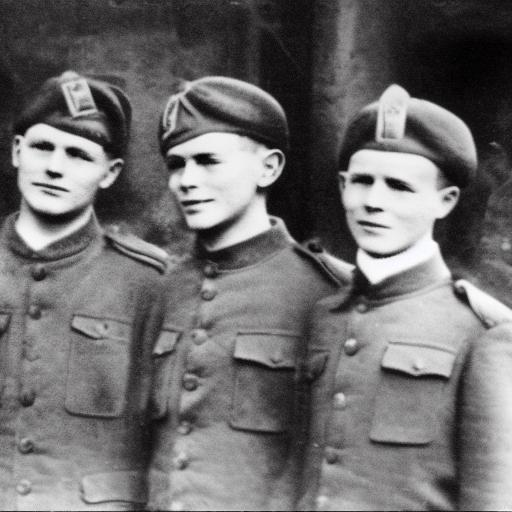

In [93]:
story_to_image(data["story"][5])